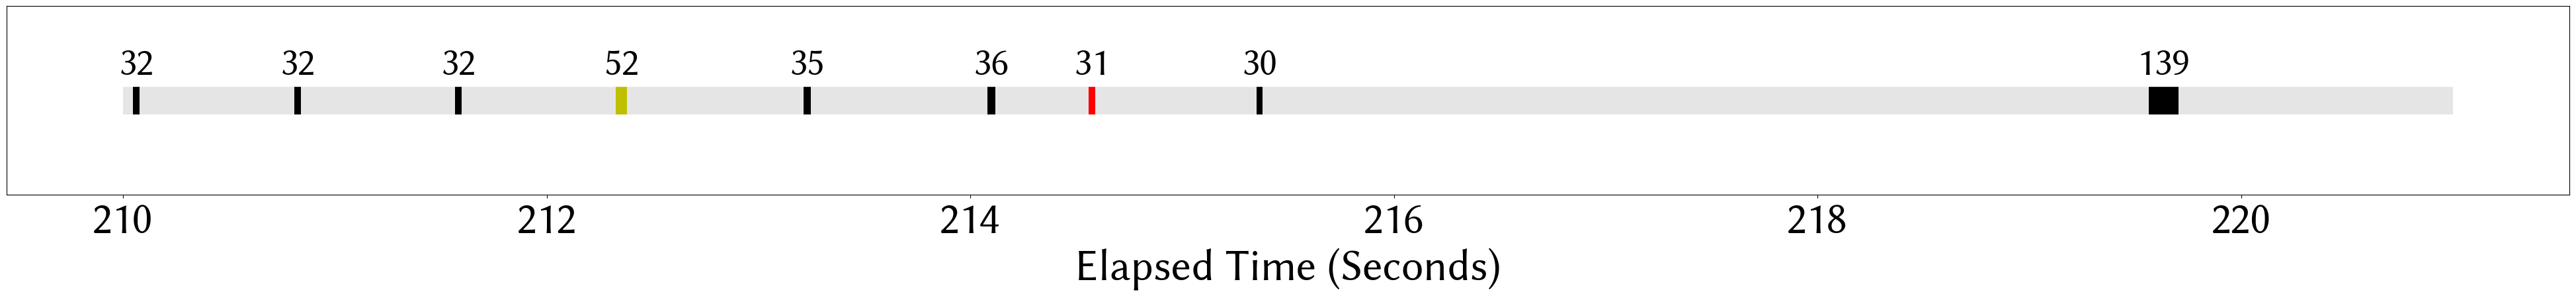

In [8]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, MinuteLocator, SecondLocator
import numpy as np
import datetime as dt
import re

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Linux Biolinum"
plt.rcParams["mathtext.fontset"] = "custom"

LABLE_FONT = 48
TICK_FONT = 48
LEGEND_FONT = 40
TAG_FONT = 42


def load_intervals(filename: str):
    with open(filename, "r") as f:
        recording = False
        pause_start: tuple[float, str] | None = None
        intervals: list[tuple[str, float, float]] = []
        for line in f:
            line = line.strip()
            # if "DaCapo 23.11-chopin h2 starting" in line:
            #     recording = True
            # if not recording:
            #     continue
            if m := re.match(r"^\[([0-9\.]+)s\]\[info\]\[gc\] GC\(\d+\) ([a-zA-Z_-]+) start\. .+$", line):
                pause_start = float(m.group(1)), m.group(2)
            if m := re.match(r"^\[([0-9\.]+)s\]\[info\]\[gc\] GC\(\d+\) ([a-zA-Z_-]+) finished\. .+$", line):
                if pause_start is not None:
                    pause_end = float(m.group(1))
                    assert pause_start[1] == m.group(2)
                    intervals.append((pause_start[1], pause_start[0], pause_end))
                    pause_start = None
    # print(intervals)
    return intervals


def plot_intervals(filename: str, limit: tuple[float, float] = (0, 1000000), legend: bool = True, save: str | None = None, xlabel: bool = True):
    height = 30
    plt.figure(figsize=(50, 3.7))
    intervals = load_intervals(filename)
    intervals = [i for i in intervals if limit[0] <= i[1] and i[2] <= limit[1]]
    # get first CM cycle +- 3 pauses
    first_initial_mark_index = next(i for i, x in enumerate(intervals) if x[0] == "InitialMark")
    first_final_mark_index = next(i for i, x in enumerate(intervals) if x[0] == "FinalMark")
    start = max(0, first_initial_mark_index - 3)
    end = min(len(intervals), first_final_mark_index + 3)
    intervals = intervals[start:end]
    # Background
    plt.hlines([0], [limit[0]], [limit[1]], "k", lw=height, alpha=0.1, label="_nolegend_")
    # RC pauses
    start = [i[1] for i in intervals if i[0] == "RefCount"]
    end = [i[2] for i in intervals if i[0] == "RefCount"]
    ys = np.zeros_like(start)
    plt.hlines(ys, start, end, "k", lw=height)
    # InitialMark pauses
    start = [i[1] for i in intervals if i[0] == "InitialMark"]
    end = [i[2] for i in intervals if i[0] == "InitialMark"]
    ys = np.zeros_like(start)
    plt.hlines(ys, start, end, "y", lw=height)
    # FinalMark pauses
    start = [i[1] for i in intervals if i[0] == "FinalMark"]
    end = [i[2] for i in intervals if i[0] == "FinalMark"]
    ys = np.zeros_like(start)
    plt.hlines(ys, start, end, "r", lw=height)
    # Full pauses
    start = [i[1] for i in intervals if i[0] == "Full"]
    end = [i[2] for i in intervals if i[0] == "Full"]
    ys = np.zeros_like(start)
    plt.hlines(ys, start, end, "m", lw=height)
    for i in range(len(intervals)):
        pt = (intervals[i][2] - intervals[i][1]) * 1000
        plt.text((intervals[i][1] + intervals[i][2]) / 2, 0.01, f"{pt:.0f}", fontsize=TAG_FONT, va="bottom", ha="center")
    if xlabel:
        plt.xlabel("Elapsed Time (Seconds)", fontsize=LABLE_FONT)
    plt.yticks([])
    plt.xticks(fontsize=TICK_FONT)
    if legend:
        plt.legend(["RC Pause", "Initial SATB Pause", "Final SATB Pause"], loc="right", fontsize=LEGEND_FONT, facecolor="white", framealpha=1)
    if save:
        plt.savefig(save, format="pdf", pad_inches=0.1, bbox_inches="tight")
    plt.show()


plot_intervals("../../evaluation/results/log/lxr-h2-large-log-boar-2024-06-05-Wed-004622/lxr-2x.log", limit=(210, 221), legend=False, save="../../h2-pauses-2x-jun2024.pdf")

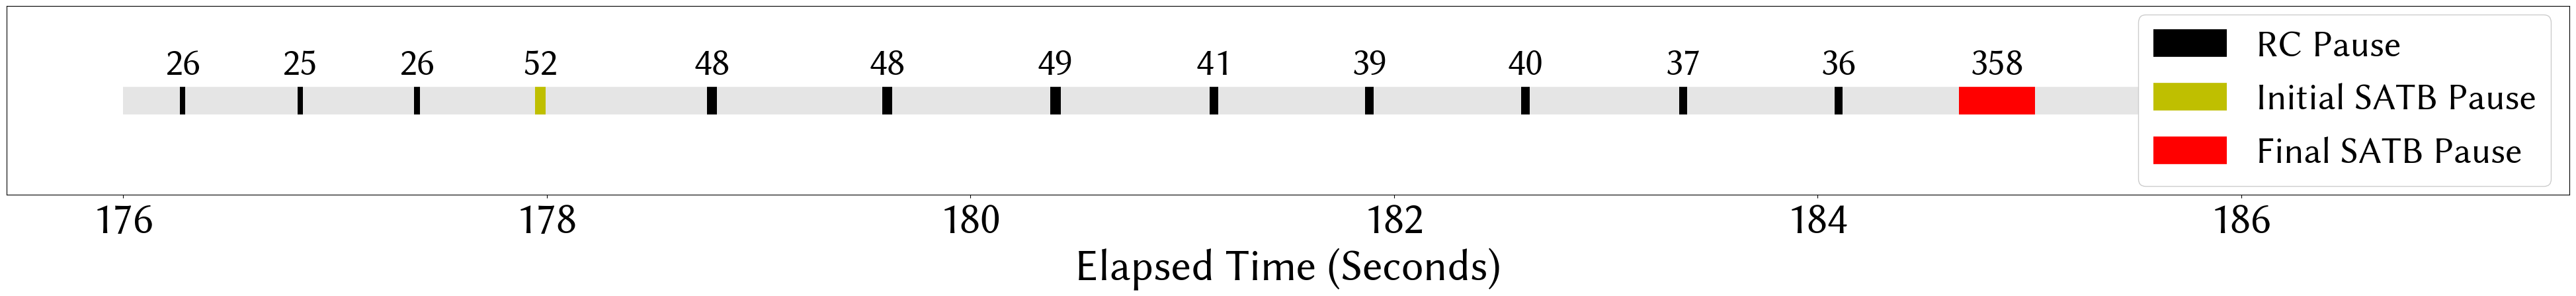

In [9]:
plot_intervals("../../evaluation/results/log/lxr-h2-large-log-boar-2024-06-05-Wed-004622/lxr-jul2023-2x.log", limit=(176, 187), save="../../h2-pauses-2x-jul2023.pdf")